# NIFTY 50 Financial Analytics Case Study  
## 02 - Feature Engineering  

This notebook transforms cleaned NIFTY 50 historical data into predictive financial features.

Feature engineering converts raw market data into structured indicators capturing:

- Trend
- Momentum
- Volatility
- Market participation
- Mean reversion behavior

All features are constructed strictly using historical information to prevent look-ahead bias.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)

In [18]:
df = pd.read_csv("../data/nifty50_raw_cleaned.csv")

df["Date"] = pd.to_datetime(df["Date"])

# Force numeric conversion on ALL non-date columns
for col in df.columns:
    if col != "Date":
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Remove any corrupted rows
df = df.dropna()

df = df.sort_values("Date")
df.reset_index(drop=True, inplace=True)

df = df.copy()

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3928 entries, 0 to 3927
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        3928 non-null   datetime64[ns]
 1   Close       3928 non-null   float64       
 2   High        3928 non-null   float64       
 3   Low         3928 non-null   float64       
 4   Open        3928 non-null   float64       
 5   Volume      3928 non-null   float64       
 6   Log_Return  3928 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 214.9 KB


,Date,Close,High,Low,Open,Volume,Log_Return
0,2010-01-05,5277.899902,5288.350098,5242.399902,5277.149902,0.0,0.008696
1,2010-01-06,5281.799805,5310.850098,5260.049805,5278.149902,0.0,0.000739
2,2010-01-07,5263.100098,5302.549805,5244.750000,5281.799805,0.0,-0.003547
3,2010-01-08,5244.750000,5276.750000,5234.700195,5264.250000,0.0,-0.003493
4,2010-01-11,5249.399902,5287.200195,5227.799805,5263.799805,0.0,0.000886


## Why Use Returns Instead of Prices?

Financial prices are non-stationary and exhibit long-term upward trends.

Returns are preferred because:

- They stabilize variance
- Remove long-term trend bias
- Reflect actual investment gain/loss
- Align with financial theory

All derived features will be based on price transformations or returns.

## Trend Indicators – Moving Averages

Moving averages smooth short-term fluctuations and capture trend direction.

Short-term averages reflect momentum.
Long-term averages reflect structural trend.

Moving average crossovers are widely used trading signals.

In [19]:
# Short-term trend
df["SMA_10"] = df["Close"].rolling(window=10).mean()

# Medium-term trend
df["SMA_20"] = df["Close"].rolling(window=20).mean()

# Long-term trend
df["SMA_50"] = df["Close"].rolling(window=50).mean()

# Exponential Moving Average
df["EMA_10"] = df["Close"].ewm(span=10, adjust=False).mean()

## Rolling Volatility

Volatility measures dispersion of returns and reflects market uncertainty.

Periods of high volatility are typically associated with:
- Financial crises
- Structural breaks
- Market stress

Volatility clustering is a well-known phenomenon in financial markets.

In [20]:
df["Volatility_10"] = df["Log_Return"].rolling(window=10).std()
df["Volatility_20"] = df["Log_Return"].rolling(window=20).std()

## Momentum Indicators – RSI

The Relative Strength Index (RSI) measures the speed and magnitude of price changes.

RSI identifies:
- Overbought conditions (>70)
- Oversold conditions (<30)

Momentum effects are well-documented in empirical finance literature.

In [22]:
window = 14

delta = df["Close"].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)

avg_gain = gain.rolling(window=window).mean()
avg_loss = loss.rolling(window=window).mean()

rs = avg_gain / avg_loss
df["RSI"] = 100 - (100 / (1 + rs))

## Lag Features

Lagged returns help capture short-term autocorrelation patterns.

Financial markets sometimes exhibit short-term persistence or reversal effects.

In [23]:
df["Return_Lag1"] = df["Log_Return"].shift(1)
df["Return_Lag2"] = df["Log_Return"].shift(2)
df["Return_Lag3"] = df["Log_Return"].shift(3)

## Volume-Based Features

Trading volume reflects investor participation and liquidity.

Volume spikes may indicate strong conviction moves or trend confirmation.

In [25]:
df["Volume_Change"] = df["Volume"].pct_change()
df["Volume_SMA_10"] = df["Volume"].rolling(10).mean()

## Target Variable Construction

We define the prediction target as next-day market direction.

If next day's return > 0 → Target = 1 (Market Up)  
Else → Target = 0 (Market Down)

The shift(-1) ensures prediction uses only historical information.

In [26]:
df["Target"] = (df["Log_Return"].shift(-1) > 0).astype(int)

In [27]:
df = df.dropna()
df.reset_index(drop=True, inplace=True)

df.head()

,Date,Close,High,Low,Open,Volume,Log_Return,SMA_10,SMA_20,SMA_50,EMA_10,Volatility_10,Volatility_20,RSI,Return_Lag1,Return_Lag2,Return_Lag3,Volume_Change,Volume_SMA_10,Target
0,2013-01-21,6082.299805,6094.350098,6065.100098,6085.750000,130900.0,0.002947,6016.154980,5973.07251,5857.329990,6024.030449,0.006133,0.006739,69.999945,0.004164,0.006204,-0.009081,inf,13090.0,0
1,2013-01-22,6048.500000,6101.299805,6040.500000,6080.149902,129000.0,-0.005573,6020.834961,5983.11250,5863.811992,6028.479458,0.006522,0.006236,57.107931,0.002947,0.004164,0.006204,-0.014515,25990.0,1
2,2013-01-23,6054.299805,6069.799805,6021.149902,6052.850098,137000.0,0.000958,6029.114941,5993.03999,5869.695986,6033.174067,0.006195,0.006238,55.922763,-0.005573,0.002947,0.004164,0.062016,39690.0,0
3,2013-01-24,6019.350098,6065.299805,6007.850098,6046.200195,185200.0,-0.005789,6034.184961,5998.72749,5875.307988,6030.660618,0.006587,0.006234,50.393628,0.000958,-0.005573,0.002947,0.351825,58210.0,1
4,2013-01-25,6074.649902,6080.549805,6014.450195,6024.500000,147600.0,0.009145,6046.519971,6008.95498,5883.075986,6038.658669,0.006918,0.006262,59.935496,-0.005789,0.000958,-0.005573,-0.203024,72970.0,1


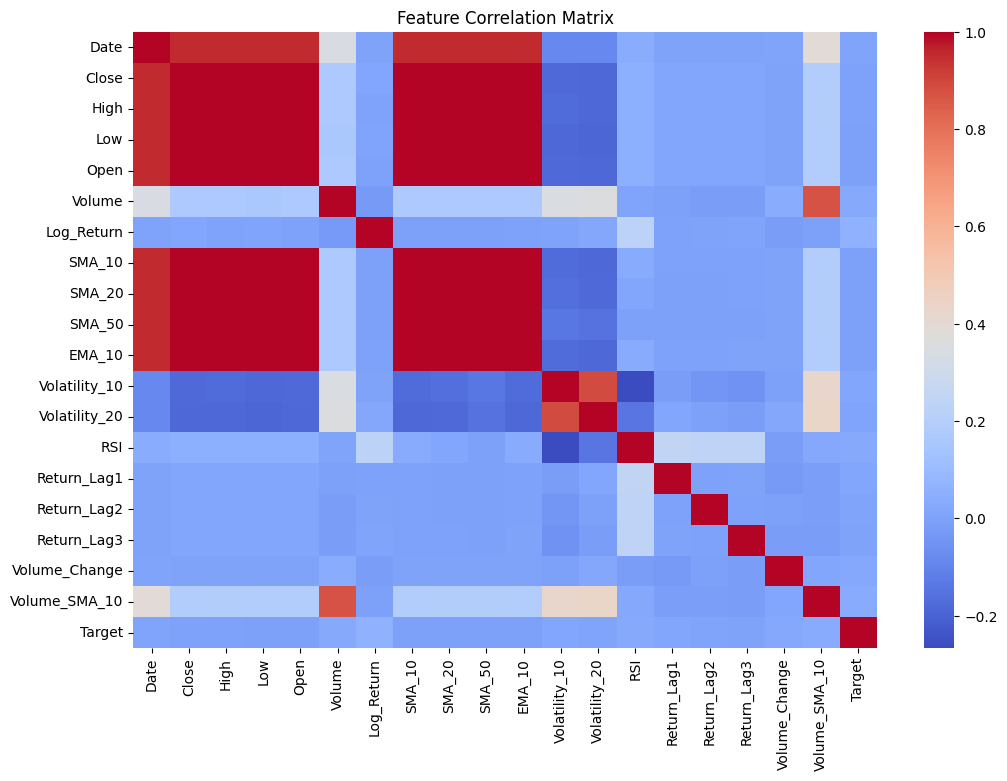

In [28]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

## Multicollinearity Discussion

Highly correlated features may impact linear models.

Tree-based models are more robust to correlated predictors.

Feature importance and regularization will address redundancy in the modeling phase.

## Look-Ahead Bias Prevention

All rolling statistics use only past observations.

The target is shifted forward.

No feature incorporates future data.

The dataset preserves realistic predictive structure.

In [29]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,3179,2019-07-18 02:53:02.132746240,2013-01-21 00:00:00,2016-04-28 12:00:00,2019-07-23 00:00:00,2022-10-10 12:00:00,2025-12-31 00:00:00,NaN
Close,3179.0,13345.316067,5285.0,8419.0,11118.0,17770.075195,26216.050781,5985.407075
High,3179.0,13414.807313,5317.700195,8464.100098,11179.549805,17842.450195,26325.800781,6007.925227
Low,3179.0,13272.86322,5118.850098,8362.875,11049.5,17673.375,26172.400391,5960.840571
Open,3179.0,13353.211341,5233.450195,8415.574707,11135.0,17786.625,26325.800781,5985.665125
Volume,3179.0,297767.348223,0.0,176750.0,246700.0,351000.0,1811000.0,183405.801835
Log_Return,3179.0,0.000456,-0.139038,-0.004338,0.000643,0.005889,0.084003,0.010256
SMA_10,3179.0,13317.213403,5392.875,8417.669971,11107.204883,17725.7875,26098.900195,5970.545792
SMA_20,3179.0,13286.015922,5472.894995,8399.487549,11086.287549,17685.95376,26031.812695,5954.373819
SMA_50,3179.0,13191.539282,5694.245,8362.435498,11087.604043,17549.281582,25938.130117,5904.340473


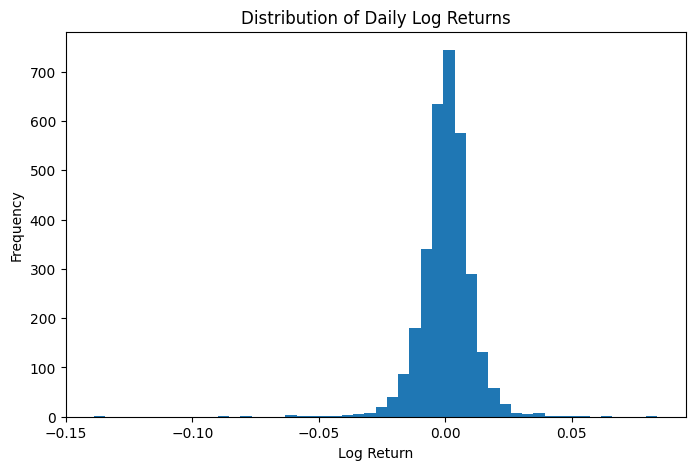

In [32]:
plt.figure(figsize=(8,5))
plt.hist(df["Log_Return"], bins=50)
plt.title("Distribution of Daily Log Returns")
plt.xlabel("Log Return")
plt.ylabel("Frequency")
plt.show()

### Distribution Analysis

Daily financial returns typically exhibit:

- Fat tails (extreme values occur more frequently than normal distribution predicts)
- Slight skewness
- Heavy volatility clustering

This deviation from normality is a well-known characteristic of financial time series.

In [33]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df["Log_Return"])

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

ADF Statistic: -15.744601597163234
p-value: 1.2440912914611135e-28


## Stationarity Test (ADF)

The Augmented Dickey-Fuller (ADF) test checks for the presence of a unit root.

Null Hypothesis (H0): The series is non-stationary.  
Alternative Hypothesis (H1): The series is stationary.

The obtained p-value is effectively zero (p ≈ 0.0000).

Since p-value < 0.05, we reject the null hypothesis of non-stationarity.

This confirms that daily log returns are stationary, which aligns with financial theory.

In contrast, price levels are typically non-stationary.

This validates the decision to model returns instead of raw prices.

In [30]:
assert "Target" in df.columns
assert df.isnull().sum().sum() == 0

print("Feature engineering completed successfully.")

Feature engineering completed successfully.


In [31]:
df.to_csv("../data/nifty50_features.csv", index=False)